In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
from sklearn.model_selection import train_test_split

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Sep  3 11:34:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import shutil
import os



zip_file_18000_path = "/content/drive/My Drive/output_folder_18000.zip"

output_folder_18000 = "/content/output_folder_18000"



if os.path.exists(output_folder_18000):
    shutil.rmtree(output_folder_18000)

output_folder_9000 = "/content/"
output_folder_18000 = "/content/"


# Unzip
with zipfile.ZipFile(zip_file_18000_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder_18000)

print("Unzipping and refreshing completed.")

Unzipping and refreshing completed.


In [ ]:
# Define the paths to the class folders
output_subfolder_0 = "/content/output_folder_18000/0"
output_subfolder_1 = "/content/output_folder_18000/1"

# Collect file paths of images from class 0
class_0_images = [os.path.join(output_subfolder_0, filename) for filename in os.listdir(output_subfolder_0)]

# Collect file paths of images from class 1
class_1_images = [os.path.join(output_subfolder_1, filename) for filename in os.listdir(output_subfolder_1)]

# Combine the lists of file paths from both classes into a single list (all_data)
all_data = class_0_images + class_1_images

train_data, temp_data = train_test_split(all_data, test_size=0.3, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [ ]:
import os
import shutil

# Create directories for training, validation, and test data
train_dir = '/content/CNNData/train'
validation_dir = '/content/CNNData/validation'
test_dir = '/content/CNNData/test'

# Organize data into class subdirectories
for image_path in train_data:
    class_folder = os.path.basename(os.path.dirname(image_path))
    destination_dir = os.path.join(train_dir, class_folder)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(image_path, destination_dir)

for image_path in valid_data:
    class_folder = os.path.basename(os.path.dirname(image_path))
    destination_dir = os.path.join(validation_dir, class_folder)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(image_path, destination_dir)

for image_path in test_data:
    class_folder = os.path.basename(os.path.dirname(image_path))
    destination_dir = os.path.join(test_dir, class_folder)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(image_path, destination_dir)


In [ ]:
train_dir = '/content/CNNData/train'
validation_dir = '/content/CNNData/validation'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Directory path to your test data
    target_size=(50, 50),  # Adjust to the target size you used during training
    batch_size=32,  # Adjust to match your batch size
    class_mode='binary'  # Adjust based on your classification task
)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(50, 50),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(50, 50),
        batch_size=32,
        class_mode='binary')

Found 2700 images belonging to 2 classes.
Found 12600 images belonging to 2 classes.
Found 2700 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 model without top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build your custom model on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Fine-tuning specific layers
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Train the model using the data generators
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # You can adjust the number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Save the trained model
model.save('/content/model_VGG16_18000.h5')

58889256/58889256 [==============================] - 3s 0us/step


Epoch 1/10
394/394 [==============================] - 30s 51ms/step - loss: 0.5150 - accuracy: 0.7610 - val_loss: 0.4790 - val_accuracy: 0.7852
Epoch 2/10
394/394 [==============================] - 18s 46ms/step - loss: 0.4856 - accuracy: 0.7815 - val_loss: 0.4765 - val_accuracy: 0.7793
Epoch 3/10
394/394 [==============================] - 18s 46ms/step - loss: 0.4720 - accuracy: 0.7852 - val_loss: 0.4682 - val_accuracy: 0.7815
Epoch 4/10
394/394 [==============================] - 18s 46ms/step - loss: 0.4680 - accuracy: 0.7877 - val_loss: 0.4591 - val_accuracy: 0.7852
Epoch 5/10
394/394 [==============================] - 18s 46ms/step - loss: 0.4635 - accuracy: 0.7883 - val_loss: 0.4505 - val_accuracy: 0.7959
Epoch 6/10
394/394 [==============================] - 18s 46ms/step - loss: 0.4614 - accuracy: 0.7920 - val_loss: 0.4647 - val_accuracy: 0.7796
Epoch 7/10
394/394 [==============================] - 18s 46ms/step - loss: 0.4554 - accuracy: 0.7910 - val_loss: 0.4513 - val_accuracy:

<ipython-input-11-0ee92d5c4241>:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = loaded_model.evaluate_generator(test_generator, steps=len(test_generator))


Test accuracy: 0.78


<ipython-input-11-0ee92d5c4241>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = loaded_model.predict_generator(test_generator, steps=len(test_generator))


Confusion Matrix:
[[670 697]
 [614 719]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.52      0.49      0.51      1367
     Class 1       0.51      0.54      0.52      1333

    accuracy                           0.51      2700
   macro avg       0.51      0.51      0.51      2700
weighted avg       0.51      0.51      0.51      2700



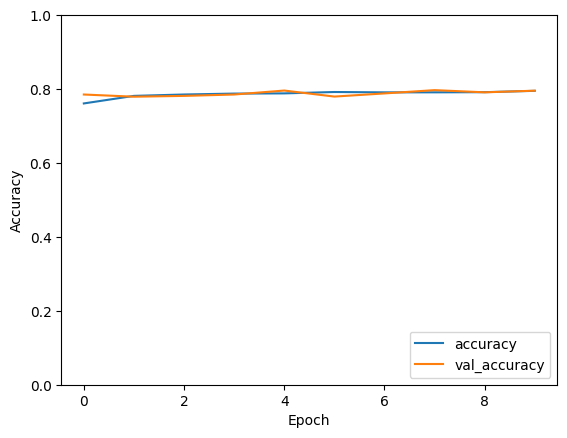

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report


# Load the trained model
loaded_model = load_model('/content/model_VGG16_18000.h5')

# Evaluate the model on the test data
test_loss, test_acc = loaded_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc:.2f}")

# Generate predictions
test_predictions = loaded_model.predict_generator(test_generator, steps=len(test_generator))
test_predictions = (test_predictions > 0.5)  # Convert probabilities to binary predictions

# Calculate confusion matrix and classification report
cm = confusion_matrix(test_generator.classes, test_predictions)
report = classification_report(test_generator.classes, test_predictions, target_names=['Class 0', 'Class 1'])

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

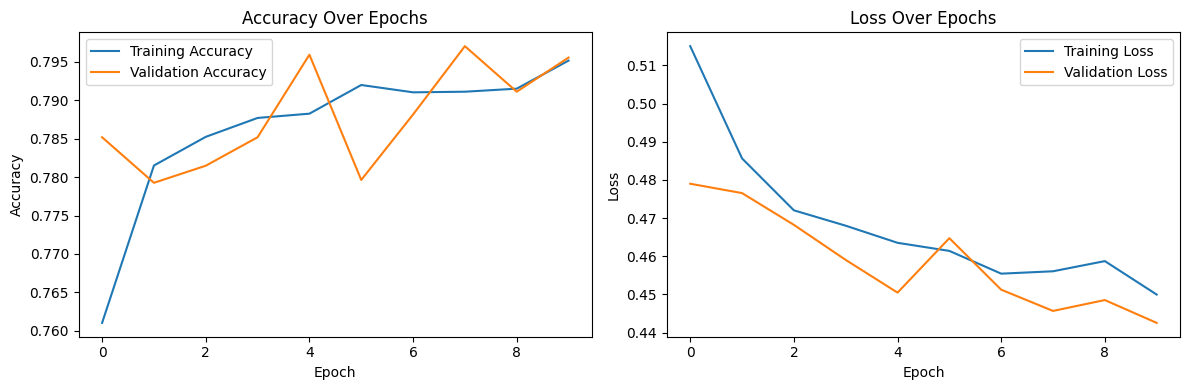

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define data directories
train_dir = '/content/CNNData/train'
validation_dir = '/content/CNNData/validation'

# Define data generators with more aggressive data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create data generators
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust based on the target size VGG16 expects
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# Load VGG16 model with pre-trained weights and without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tuning specific layers (only blocks 4 and 5)
for layer in base_model.layers:
    if 'block4' in layer.name or 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Train the model
epochs = 30  # You can adjust the number of epochs based on the results
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Save the trained model
model.save('/content/model_VGG16_18000_fine_tuned.h5')

Found 12600 images belonging to 2 classes.
Found 2700 images belonging to 2 classes.
Epoch 1/30
197/197 [==============================] - 215s 949ms/step - loss: 0.4472 - accuracy: 0.8005 - val_loss: 0.4142 - val_accuracy: 0.8311
Epoch 2/30
197/197 [==============================] - 170s 860ms/step - loss: 0.3970 - accuracy: 0.8278 - val_loss: 0.3657 - val_accuracy: 0.8452
Epoch 3/30
197/197 [==============================] - 171s 865ms/step - loss: 0.3743 - accuracy: 0.8437 - val_loss: 0.3443 - val_accuracy: 0.8611
Epoch 4/30
197/197 [==============================] - 171s 863ms/step - loss: 0.3680 - accuracy: 0.8490 - val_loss: 0.3296 - val_accuracy: 0.8659
Epoch 5/30
197/197 [==============================] - 171s 864ms/step - loss: 0.3529 - accuracy: 0.8540 - val_loss: 0.3614 - val_accuracy: 0.8474
Epoch 6/30
197/197 [==============================] - 171s 866ms/step - loss: 0.3422 - accuracy: 0.8591 - val_loss: 0.3090 - val_accuracy: 0.8796
Epoch 7/30
197/197 [===================

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')
model.save('/content/gdrive/MyDrive/model_VGG16_fine_tuned.h5')

Mounted at /content/gdrive


<ipython-input-15-efa12052a81f>:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = loaded_model.evaluate_generator(test_generator, steps=len(test_generator))


Test accuracy: 0.81


<ipython-input-15-efa12052a81f>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = loaded_model.predict_generator(test_generator, steps=len(test_generator))


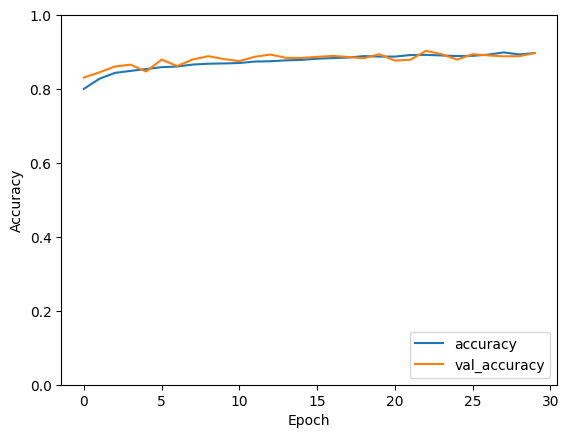

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report


# Load the trained model
loaded_model = load_model('/content/model_VGG16_18000_fine_tuned.h5')

# Evaluate the model on the test data
test_loss, test_acc = loaded_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc:.2f}")

# Generate predictions
test_predictions = loaded_model.predict_generator(test_generator, steps=len(test_generator))
test_predictions = (test_predictions > 0.5)  # Convert probabilities to binary predictions

# Calculate confusion matrix and classification report
cm = confusion_matrix(test_generator.classes, test_predictions)
report = classification_report(test_generator.classes, test_predictions, target_names=['Class 0', 'Class 1'])

# print("Confusion Matrix:")
# print(cm)
# print("\nClassification Report:")
# print(report)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

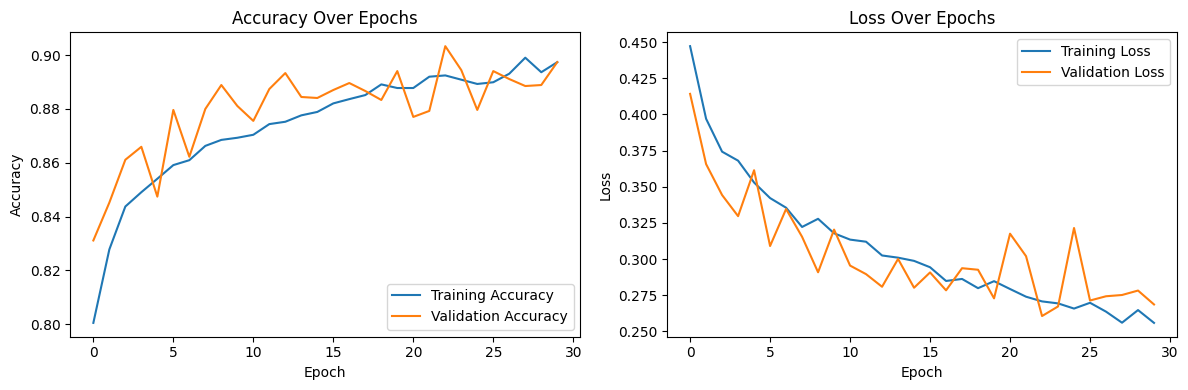

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()